In [1]:
from preprocessing import (
    preprocess_kjv,
    get_word_types_with_tf_idf,
)
from extract_relations import (
    get_directed_relations,
    order_directed_relations,
)
from ontology_algorithm import (
    construct_ontology_hierarchy,
    print_hierarchy_tree_from_ontology,
    draw_hierarchy_tree_from_ontology,
)

## Preprocessing

We will preprocess words from the kjv Bible using tf-idf and extract the top n words.

In [2]:
kjv_path = "/Users/zebo/Documents/Freelancing/upwork/Peter_J_Worth_Jr/NLP/hierarchical_clustering/data/t_kjv.csv"
kjv_bible_df, genesis_df = preprocess_kjv(
    path_to_kjv=kjv_path,
    get_book="Genesis",
)


Genesis_parts = [0, 11, 26, 37, 51]

# Specify the number of chapters to use.
last_chapter = 50
# Specify the number of top words to use.
n = 30

selected_chapter_verses = []
for chapter_index in range(1, last_chapter + 1):
    chapter = genesis_df[genesis_df["chapter"] == chapter_index]
    chapter_verses = ""
    for verse in chapter["text"].values:
        chapter_verses = chapter_verses + " " + verse
        if "the LORD" in verse and "the LORD God" not in verse:
            # replace "the LORD" with "God"
            verse = verse.replace("the LORD", "God")  # TODO change?
    selected_chapter_verses.append(chapter_verses)

tf_idf_pre_filtering = get_word_types_with_tf_idf(
    selected_chapter_verses,
    "tf_idf",
    skip_stopwords=True,
    include_verbs=False,
    include_determiners=False,
    include_pronouns=False,
    include_adverbs=False,
    include_numbers=False,
)

top_n_words = tf_idf_pre_filtering.head(n)["word"].values

# Extract relations from the corpus

In [3]:
# Create a list of all verses of the corpus.
all_verses = []
for chapter_index in range(1, last_chapter + 1):
    Chapter = genesis_df[genesis_df["chapter"] == chapter_index]
    chapter_verses = []
    for verse in Chapter["text"].values:
        if "the LORD" in verse and "the LORD God" not in verse:
            # replace "the LORD" with "God"
            # optional, better clarity
            verse = verse.replace("the LORD", "God")
        chapter_verses.append(verse)
    all_verses.extend(chapter_verses)

Example of spacy dependency trees. These we parse in the `get_directed_relations` method from `extract_relations.py`:

In [4]:
import spacy

nlp = spacy.load("en_core_web_lg")
doc_1 = nlp(all_verses[50])
spacy.displacy.render(doc_1, style="dep", jupyter=True)

In [5]:
directed_relations, relations_to_verbs = get_directed_relations(
    top_n_words=top_n_words,
    all_verses=all_verses,
    verbose=True,
)


 1  sentences in verse  0
sentence:  In the beginning God created the heaven and the earth.
ents:  []
subject:  God
object:  beginning
object:  heaven
Adding relation: ' god ' -> ' earth '

 2  sentences in verse  1
sentence:  And the earth was without form, and void; and darkness was upon the face of the deep.
ents:  []
subject:  earth
object:  form
subject:  darkness
object:  face
object:  deep
sentence:  And the Spirit of God moved upon the face of the waters.
ents:  []
subject:  Spirit
object:  face
object:  waters

 1  sentences in verse  2
sentence:  And God said, Let there be light: and there was light.
ents:  []
subject:  God
Using conjunct subject:  God

 1  sentences in verse  3
sentence:  And God saw the light, that it was good: and God divided the light from the darkness.
ents:  []
subject:  God
object:  light
subject:  it
subject:  God
object:  light
object:  darkness

 2  sentences in verse  4
sentence:  And God called the light Day, and the darkness he called Night.
ent

In [6]:
for key, value in relations_to_verbs.items():
    print(key, value)

('god', 'abraham') ['said', 'said', 'went', 'said', 'bring', 'left', 'remembered', 'said', 'tempt', 'blessed', 'gave', 'sware']
('joseph', 'brethren') ['feeding', 'told', 'went', 'come', 'saw', 'knew', 'said', 'said', 'said', 'placed', 'said']
('god', 'noah') ['said', 'said', 'commanded', 'remembered', 'spake', 'blessed', 'spake', 'said']
('joseph', 'egypt') ['brought', 'went', 'stood', 'went', 'bought', 'returned', 'dwelt', 'put']
('joseph', 'pharaoh') ['answered', 'said', 'went', 'told', 'set', 'bought', 'spake', 'went']
('god', 'earth') ['created', 'called', 'made', 'made', 'looked', 'scattered', 'scatter']
('jacob', 'laban') ['saw', 'said', 'said', 'beheld', 'stole', 'said', 'said']
('pharaoh', 'joseph') ['said', 'said', 'said', 'said', 'said', 'said', 'spake']
('jacob', 'rachel') ['saw', 'kissed', 'told', 'loved', 'served', 'called']
('laban', 'jacob') ['heard', 'said', 'overtook', 'said', 'said', 'said']
('joseph', 'father') ['brought', 'placed', 'nourished', 'said', 'said', 'bur

In [7]:
ordered_directed_relations = order_directed_relations(
    directed_relations=directed_relations,
    tf_idf_pre_filtering=tf_idf_pre_filtering,
    order_by="product",
    include_ordering_wrt_occurences=True,
    verbose=True,
)
ordered_directed_relations

                relation  occurances
0         (god, abraham)          12
1     (joseph, brethren)          11
2            (god, noah)           8
3        (joseph, egypt)           8
4      (joseph, pharaoh)           8
5           (god, earth)           7
6         (jacob, laban)           7
7       (joseph, father)           6
8        (jacob, rachel)           6
9           (god, abram)           5
10        (isaac, jacob)           5
11  (abimelech, abraham)           5
12       (waters, earth)           5
13            (god, son)           4
14         (isaac, esau)           4
15          (god, dream)           3
16          (god, jacob)           3
17         (god, father)           3
18         (jacob, sons)           3
19     (jacob, brethren)           3
20      (jacob, pharaoh)           3
21        (abraham, son)           3
22      (abraham, sarah)           3
23       (abraham, sons)           3
24        (esau, father)           3
25          (sarah, son)           3
2

[('god', 'abraham'),
 ('joseph', 'brethren'),
 ('god', 'noah'),
 ('joseph', 'egypt'),
 ('joseph', 'pharaoh'),
 ('god', 'earth'),
 ('jacob', 'laban'),
 ('joseph', 'father'),
 ('jacob', 'rachel'),
 ('god', 'abram'),
 ('isaac', 'jacob'),
 ('abimelech', 'abraham'),
 ('waters', 'earth'),
 ('god', 'son'),
 ('isaac', 'esau'),
 ('god', 'dream'),
 ('god', 'jacob'),
 ('god', 'father'),
 ('jacob', 'sons'),
 ('jacob', 'brethren'),
 ('jacob', 'pharaoh'),
 ('abraham', 'son'),
 ('abraham', 'sarah'),
 ('abraham', 'sons'),
 ('esau', 'father'),
 ('sarah', 'son'),
 ('god', 'pharaoh'),
 ('god', 'abimelech'),
 ('god', 'sarah'),
 ('god', 'master'),
 ('god', 'joseph'),
 ('jacob', 'father'),
 ('abraham', 'isaac'),
 ('isaac', 'son'),
 ('esau', 'jacob'),
 ('sons', 'daughters'),
 ('laban', 'daughters'),
 ('laban', 'rachel'),
 ('abram', 'egypt'),
 ('noah', 'ark'),
 ('abimelech', 'isaac'),
 ('daughters', 'isaac'),
 ('god', 'waters'),
 ('god', 'ark'),
 ('god', 'sons'),
 ('god', 'daughters'),
 ('god', 'lot'),
 ('god

## Construct the ontology hierarchy

In [8]:
ontology_hierarchy, words_with_parents = construct_ontology_hierarchy(
    ordered_directed_relations=ordered_directed_relations,
)
print_hierarchy_tree_from_ontology(
    ontological_hierarchy=ontology_hierarchy,
    words_with_parents=words_with_parents,
)

god
├── abraham
│   ├── sarah
│   └── isaac
│       ├── jacob
│       │   ├── laban
│       │   ├── rachel
│       │   ├── sons
│       │   │   └── daughters
│       │   ├── daughter
│       │   └── years
│       └── esau
├── noah
│   └── ark
├── earth
├── abram
├── son
├── dream
├── abimelech
├── master
├── joseph
│   ├── brethren
│   ├── egypt
│   ├── pharaoh
│   ├── father
│   └── king
├── waters
├── lot
└── brother


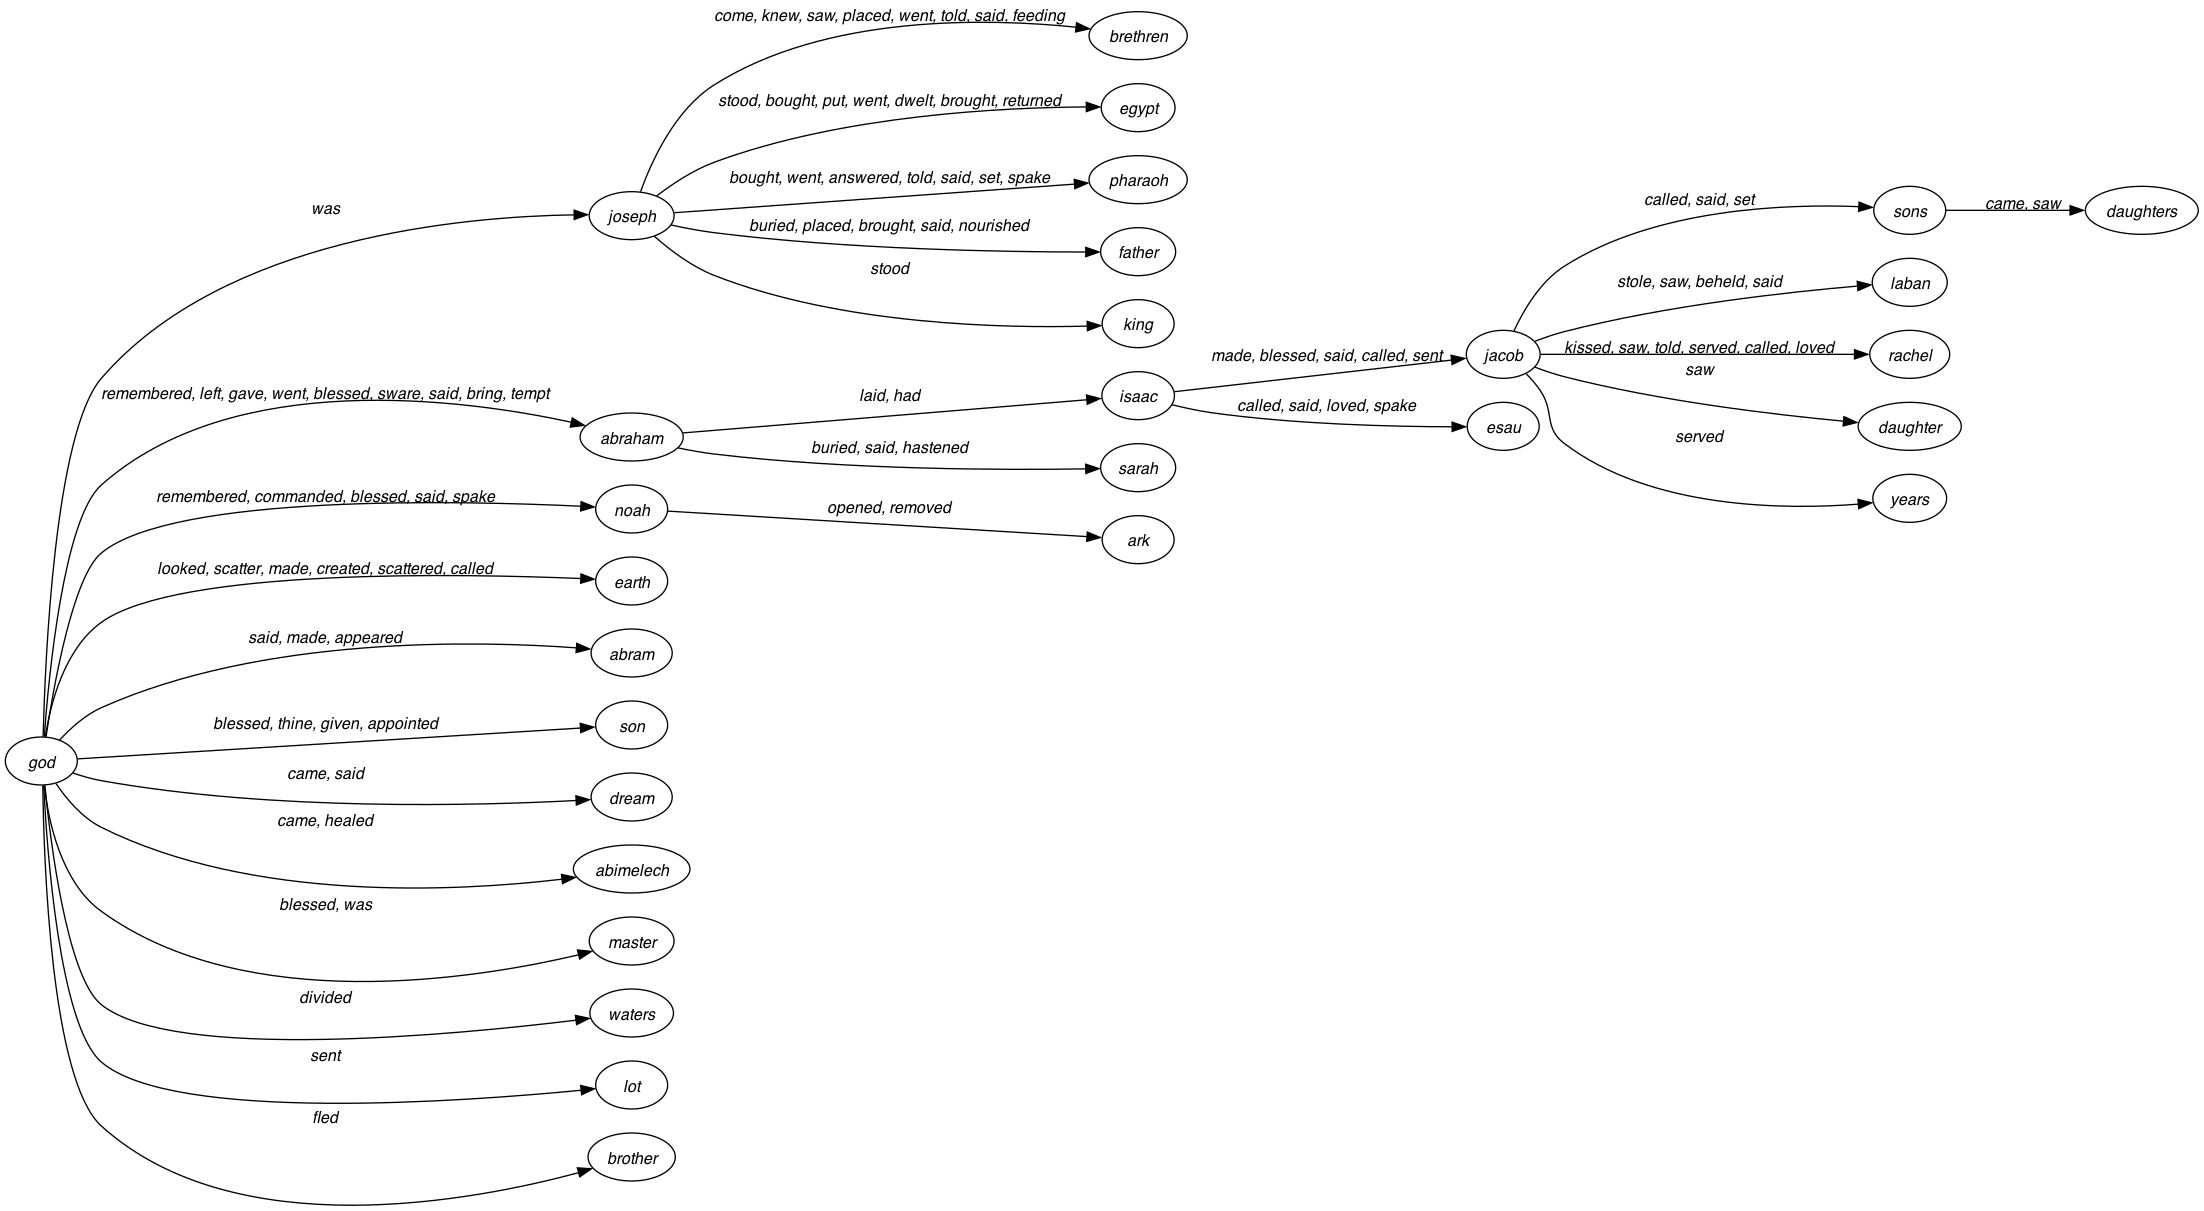

In [9]:
draw_hierarchy_tree_from_ontology(
    ontological_hierarchy=ontology_hierarchy,
    relations_to_verbs=relations_to_verbs,
)